In [ ]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 21.0 MB/s eta 0:00:00


In [ ]:
# Standard library imports
import os
import sys
import json
import pickle
import random
import re
from glob import glob
from pathlib import Path

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
from tqdm import tqdm
import scipy

# PyTorch imports
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# torchvision imports
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.datasets import VisionDataset
import torchvision.transforms as T

# PIL imports
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
import scipy.stats as stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/dermoscopic_artifacts')
sys.path.append('/content/drive/MyDrive/dermoscopic_artifacts')
import importlib
import datasets
importlib.reload(datasets)
from datasets import ISICDataset, HAM10000Dataset, PH2Dataset, BCN20000Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Preprocessing

In [ ]:
artifacts = ["dark_corner",	"hair",	"gel_border","gel_bubble","ruler","ink","patches"]

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dermoscopic_artifacts/isic_bias.csv", index_col=0, sep=';')

In [ ]:
df

,image,dark_corner,hair,gel_border,gel_bubble,ruler,ink,patches,label,label_string
0,ISIC_0000000.png,0,0,0,0,0,0,0,0,benign
1,ISIC_0000001.png,0,1,0,1,0,0,0,0,benign
2,ISIC_0000003.png,0,1,0,1,0,0,0,0,benign
3,ISIC_0000004.png,1,1,0,1,1,0,0,1,malignant
4,ISIC_0000006.png,1,0,0,0,0,0,0,0,benign
...,...,...,...,...,...,...,...,...,...,...
2589,ISIC_0016068.png,1,0,0,1,1,0,0,0,benign
2590,ISIC_0016069.png,1,0,0,0,1,0,0,0,benign
2591,ISIC_0016070.png,1,1,0,1,1,0,0,0,benign
2592,ISIC_0016071.png,0,0,1,0,1,1,0,0,benign


In [ ]:
correlation_matrix = df[artifacts + ['label']].corr()
artifact_label_correlation = correlation_matrix["label"]

# Display correlation with label
print(artifact_label_correlation)

dark_corner    0.083676
hair          -0.077681
gel_border    -0.102704
gel_bubble     0.006752
ruler          0.100417
ink           -0.065187
patches       -0.131947
label          1.000000
Name: label, dtype: float64


In [ ]:
display(correlation_matrix)

,dark_corner,hair,gel_border,gel_bubble,ruler,ink,patches,label
dark_corner,1.000000,-0.103374,-0.144011,-0.033379,0.312700,0.081595,0.042584,0.083676
hair,-0.103374,1.000000,-0.073598,-0.036698,-0.191542,-0.144964,0.122731,-0.077681
gel_border,-0.144011,-0.073598,1.000000,-0.236224,0.338354,0.418221,0.227352,-0.102704
gel_bubble,-0.033379,-0.036698,-0.236224,1.000000,-0.172993,-0.046949,-0.242537,0.006752
ruler,0.312700,-0.191542,0.338354,-0.172993,1.000000,0.396242,-0.252100,0.100417
ink,0.081595,-0.144964,0.418221,-0.046949,0.396242,1.000000,-0.122356,-0.065187
patches,0.042584,0.122731,0.227352,-0.242537,-0.252100,-0.122356,1.000000,-0.131947
label,0.083676,-0.077681,-0.102704,0.006752,0.100417,-0.065187,-0.131947,1.000000


In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# Number of splits
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# Assign splits
for i, (train_idx, test_idx) in enumerate(kf.split(df), 1):
    df[f"split_{i}"] = "train"
    df.loc[test_idx, f"split_{i}"] = "test"

In [ ]:
df

,image,dark_corner,hair,gel_border,gel_bubble,ruler,ink,patches,label,label_string,split_1,split_2,split_3,split_4,split_5
0,ISIC_0000000.png,0,0,0,0,0,0,0,0,benign,train,train,train,test,train
1,ISIC_0000001.png,0,1,0,1,0,0,0,0,benign,train,train,train,train,test
2,ISIC_0000003.png,0,1,0,1,0,0,0,0,benign,train,train,test,train,train
3,ISIC_0000004.png,1,1,0,1,1,0,0,1,malignant,train,train,train,test,train
4,ISIC_0000006.png,1,0,0,0,0,0,0,0,benign,train,train,train,train,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,ISIC_0016068.png,1,0,0,1,1,0,0,0,benign,train,test,train,train,train
2590,ISIC_0016069.png,1,0,0,0,1,0,0,0,benign,train,train,train,test,train
2591,ISIC_0016070.png,1,1,0,1,1,0,0,0,benign,train,train,test,train,train
2592,ISIC_0016071.png,0,0,1,0,1,1,0,0,benign,test,train,train,train,train


# ISIC melanoma classification model

In [ ]:
import kagglehub
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'isic2018-challenge-task1-data-segmentation' dataset.
Path to dataset files: /kaggle/input/isic2018-challenge-task1-data-segmentation


In [ ]:
# Define paths
image_dir = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input"
mask_dir = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"

# Create dataset instances for each mode
dataset_modes = ["whole", "lesion", "background", "bbox", "bbox70", "bbox90",
                 "high_whole", "low_whole", "high_lesion", "low_lesion", "high_background", "low_background"]


In [ ]:
import kagglehub
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'isic2018-challenge-task1-data-segmentation' dataset.
Path to dataset files: /kaggle/input/isic2018-challenge-task1-data-segmentation


In [ ]:
dataset = ISICDataset(df, image_dir, mask_dir, mode="low_background", return_pil= True)

In [ ]:
print(dataset)

In [ ]:
print(len(dataset))

2594


In [ ]:
test_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg"
print("exists:", os.path.exists(test_path))

img = cv2.imread(test_path, cv2.IMREAD_COLOR)
print("img is None:", img is None)
if img is not None:
    print("shape:", img.shape)

exists: True
img is None: False
shape: (767, 1022, 3)


<PIL.Image.Image image mode=RGB size=1022x767 at 0x7E17837AB8C0>


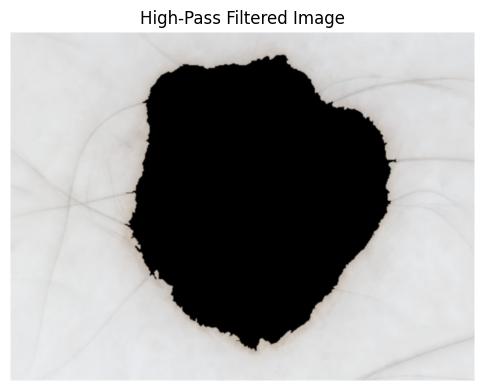

In [ ]:
high_pass_img = dataset[2][0]
print(high_pass_img)
high_pass_array = np.array(high_pass_img).astype(np.float32)  # Convert to float for scaling

# Normalize for visualization
high_pass_array = (high_pass_array - high_pass_array.min()) / (high_pass_array.max() - high_pass_array.min()) * 255
high_pass_array = high_pass_array.astype(np.uint8)  # Convert back to 8-bit

# Display the image
plt.figure(figsize=(6,6))
plt.imshow(high_pass_array)
plt.axis("off")
plt.title("High-Pass Filtered Image")
plt.show()

In [ ]:
dataloader = DataLoader(ISICDataset(df, image_dir, mask_dir, mode="low_background"), batch_size=16, shuffle=True)

In [ ]:
# Device configuration

# Training hyperparameters
num_epochs = 10  # Adjust as needed
learning_rate = 1e-4
batch_size = 32


# Select dataset mode (e.g., "whole", "lesion", etc.)
dataset_mode = "low_background"  # Change this to your desired mode

# Create a directory to save models
save_dir = f"/content/drive/MyDrive/classifiers/{dataset_mode}"
os.makedirs(save_dir, exist_ok=True)

# Load dataset for this split
full_dataset = ISICDataset(df, image_dir, mask_dir, transform=transform, mode=dataset_mode, return_pil=False)
print(df.columns.tolist())

# Loop through each split (split_1 to split_5)
for split in range(1, 6):
    print(f"Training on {dataset_mode} - Split {split}")

    train_indices = df[df[f"split_{split}"] == "train"].index.tolist()
    test_indices = df[df[f"split_{split}"] == "test"].index.tolist()

    # Create subset datasets
    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load pre-trained ResNet50
    model = models.resnet50(pretrained=True)

    # Modify the final layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1),
        nn.Sigmoid()
    )

    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        print(f"Starting epoch {epoch}")
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Ensure labels are (batch, 1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Save the trained model for this split
    model_path = f"{save_dir}/resnet50_split_{split}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

print("Training completed for all splits!")

['image', 'dark_corner', 'hair', 'gel_border', 'gel_bubble', 'ruler', 'ink', 'patches', 'label', 'label_string', 'split_1', 'split_2', 'split_3', 'split_4', 'split_5']
Training on low_background - Split 1


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 351MB/s]


Starting epoch 0


100%|██████████| 65/65 [27:07<00:00, 25.03s/it]


Epoch [1/10], Loss: 0.4719
Starting epoch 1


100%|██████████| 65/65 [24:56<00:00, 23.02s/it]


Epoch [2/10], Loss: 0.3307
Starting epoch 2


100%|██████████| 65/65 [24:15<00:00, 22.40s/it]


Epoch [3/10], Loss: 0.2085
Starting epoch 3


100%|██████████| 65/65 [24:29<00:00, 22.60s/it]


Epoch [4/10], Loss: 0.1243
Starting epoch 4


100%|██████████| 65/65 [24:30<00:00, 22.62s/it]


Epoch [5/10], Loss: 0.0861
Starting epoch 5


100%|██████████| 65/65 [24:42<00:00, 22.81s/it]


Epoch [6/10], Loss: 0.0780
Starting epoch 6


100%|██████████| 65/65 [24:52<00:00, 22.96s/it]


Epoch [7/10], Loss: 0.0501
Starting epoch 7


100%|██████████| 65/65 [25:03<00:00, 23.13s/it]


Epoch [8/10], Loss: 0.0345
Starting epoch 8


100%|██████████| 65/65 [25:17<00:00, 23.35s/it]


Epoch [9/10], Loss: 0.0396
Starting epoch 9


100%|██████████| 65/65 [24:54<00:00, 22.99s/it]


Epoch [10/10], Loss: 0.0240
Model saved to /content/drive/MyDrive/classifiers/low_background/resnet50_split_1.pth
Training on low_background - Split 2
Starting epoch 0


100%|██████████| 65/65 [25:27<00:00, 23.50s/it]


Epoch [1/10], Loss: 0.4752
Starting epoch 1


100%|██████████| 65/65 [24:52<00:00, 22.96s/it]


Epoch [2/10], Loss: 0.3159
Starting epoch 2


100%|██████████| 65/65 [24:46<00:00, 22.87s/it]


Epoch [3/10], Loss: 0.1905
Starting epoch 3


100%|██████████| 65/65 [24:38<00:00, 22.75s/it]


Epoch [4/10], Loss: 0.1277
Starting epoch 4


100%|██████████| 65/65 [24:58<00:00, 23.06s/it]


Epoch [5/10], Loss: 0.1146
Starting epoch 5


100%|██████████| 65/65 [24:49<00:00, 22.91s/it]


Epoch [6/10], Loss: 0.0583
Starting epoch 6


100%|██████████| 65/65 [24:28<00:00, 22.60s/it]


Epoch [7/10], Loss: 0.0432
Starting epoch 7


100%|██████████| 65/65 [24:32<00:00, 22.65s/it]


Epoch [8/10], Loss: 0.0416
Starting epoch 8


100%|██████████| 65/65 [24:52<00:00, 22.96s/it]


Epoch [9/10], Loss: 0.0661
Starting epoch 9


100%|██████████| 65/65 [24:57<00:00, 23.04s/it]


Epoch [10/10], Loss: 0.0412
Model saved to /content/drive/MyDrive/classifiers/low_background/resnet50_split_2.pth
Training on low_background - Split 3
Starting epoch 0


100%|██████████| 65/65 [24:53<00:00, 22.98s/it]


Epoch [1/10], Loss: 0.4749
Starting epoch 1


100%|██████████| 65/65 [24:38<00:00, 22.75s/it]


Epoch [2/10], Loss: 0.3250
Starting epoch 2


100%|██████████| 65/65 [24:54<00:00, 22.99s/it]


Epoch [3/10], Loss: 0.2085
Starting epoch 3


100%|██████████| 65/65 [24:42<00:00, 22.81s/it]


Epoch [4/10], Loss: 0.1146
Starting epoch 4


100%|██████████| 65/65 [24:45<00:00, 22.85s/it]


Epoch [5/10], Loss: 0.1004
Starting epoch 5


100%|██████████| 65/65 [25:05<00:00, 23.16s/it]


Epoch [6/10], Loss: 0.0659
Starting epoch 6


100%|██████████| 65/65 [24:43<00:00, 22.83s/it]


Epoch [7/10], Loss: 0.0383
Starting epoch 7


100%|██████████| 65/65 [24:37<00:00, 22.74s/it]


Epoch [8/10], Loss: 0.0516
Starting epoch 8


100%|██████████| 65/65 [24:34<00:00, 22.69s/it]


Epoch [9/10], Loss: 0.0403
Starting epoch 9


100%|██████████| 65/65 [24:55<00:00, 23.01s/it]


Epoch [10/10], Loss: 0.0556
Model saved to /content/drive/MyDrive/classifiers/low_background/resnet50_split_3.pth
Training on low_background - Split 4
Starting epoch 0


100%|██████████| 65/65 [24:58<00:00, 23.05s/it]


Epoch [1/10], Loss: 0.4619
Starting epoch 1


100%|██████████| 65/65 [24:51<00:00, 22.94s/it]


Epoch [2/10], Loss: 0.3161
Starting epoch 2


100%|██████████| 65/65 [24:37<00:00, 22.73s/it]


Epoch [3/10], Loss: 0.2105
Starting epoch 3


100%|██████████| 65/65 [24:45<00:00, 22.86s/it]


Epoch [4/10], Loss: 0.1275
Starting epoch 4


100%|██████████| 65/65 [24:42<00:00, 22.80s/it]


Epoch [5/10], Loss: 0.0961
Starting epoch 5


100%|██████████| 65/65 [24:42<00:00, 22.81s/it]


Epoch [6/10], Loss: 0.0605
Starting epoch 6


100%|██████████| 65/65 [24:46<00:00, 22.86s/it]


Epoch [7/10], Loss: 0.0441
Starting epoch 7


100%|██████████| 65/65 [24:27<00:00, 22.58s/it]


Epoch [8/10], Loss: 0.0564
Starting epoch 8


100%|██████████| 65/65 [24:28<00:00, 22.59s/it]


Epoch [9/10], Loss: 0.0519
Starting epoch 9


100%|██████████| 65/65 [24:36<00:00, 22.72s/it]


Epoch [10/10], Loss: 0.0436
Model saved to /content/drive/MyDrive/classifiers/low_background/resnet50_split_4.pth
Training on low_background - Split 5
Starting epoch 0


100%|██████████| 65/65 [24:33<00:00, 22.68s/it]


Epoch [1/10], Loss: 0.4731
Starting epoch 1


100%|██████████| 65/65 [25:07<00:00, 23.19s/it]


Epoch [2/10], Loss: 0.3368
Starting epoch 2


100%|██████████| 65/65 [24:54<00:00, 22.99s/it]


Epoch [3/10], Loss: 0.2006
Starting epoch 3


100%|██████████| 65/65 [24:24<00:00, 22.52s/it]


Epoch [4/10], Loss: 0.1253
Starting epoch 4


100%|██████████| 65/65 [23:36<00:00, 21.79s/it]


Epoch [5/10], Loss: 0.0936
Starting epoch 5


100%|██████████| 65/65 [24:31<00:00, 22.64s/it]


Epoch [6/10], Loss: 0.0847
Starting epoch 6


100%|██████████| 65/65 [24:42<00:00, 22.81s/it]


Epoch [7/10], Loss: 0.0470
Starting epoch 7


100%|██████████| 65/65 [24:37<00:00, 22.73s/it]


Epoch [8/10], Loss: 0.0440
Starting epoch 8


100%|██████████| 65/65 [24:25<00:00, 22.55s/it]


Epoch [9/10], Loss: 0.0351
Starting epoch 9


100%|██████████| 65/65 [24:33<00:00, 22.66s/it]

Epoch [10/10], Loss: 0.0352
Model saved to /content/drive/MyDrive/classifiers/low_background/resnet50_split_5.pth
Training completed for all splits!


In [ ]:
dataset_modes = ["low_background"]
#  ["whole", "lesion", "background", "bbox", "bbox70", "bbox90",
                #  "high_whole", "low_whole", "high_lesion", "low_lesion", "high_background", "low_background"]